In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import rdkit
from torch.utils.data import DataLoader
#from torch_gometric.datasets import MoleculeNet

#import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [7]:
import torch
import torch.nn as nn

class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x, adj):
        support = torch.mm(x, self.weight)
        output = torch.spmm(adj, support)
        return output

class Encoder(nn.Module):
    def __init__(self, num_nodes, num_features, num_edge_types, hidden_size):
        super(Encoder, self).__init__()
        self.num_nodes = num_nodes
        self.num_features = num_features
        self.num_edge_types = num_edge_types
        self.hidden_size = hidden_size

        # Define weight matrices for each edge type
        self.weights = nn.Parameter(torch.FloatTensor(num_edge_types, num_features, hidden_size))
        nn.init.xavier_uniform_(self.weights)

        # Define graph convolutional layers for each edge type
        self.gcn_layers = nn.ModuleList()
        for r in range(num_edge_types):
            self.gcn_layers.append(GraphConvolution(hidden_size, hidden_size))

    def forward(self, x, adj):
        # Compute separate message vectors for each edge type
        outputs = []
        for r in range(self.num_edge_types):
            weight_r = self.weights[r]
            message_r = torch.mm(x, weight_r)
            adj_r = adj[r]
            output_r = self.gcn_layers[r](message_r, adj_r)
            outputs.append(output_r)

        # Aggregate message vectors across all incoming edges
        output = torch.sum(torch.stack(outputs), dim=0)
        return output

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x, adj):
        support = torch.mm(x, self.weight)
        output = torch.mm(adj, support)
        return output

class Encoder(nn.Module):
    def __init__(self, num_users, num_items, num_features, num_edge_types, hidden_size):
        super(Encoder, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_features = num_features
        self.num_edge_types = num_edge_types
        self.hidden_size = hidden_size

        # Define weight matrices for user and item nodes
        self.user_weights = nn.Parameter(torch.FloatTensor(num_features, hidden_size))
        nn.init.xavier_uniform_(self.user_weights)
        self.item_weights = nn.Parameter(torch.FloatTensor(num_features, hidden_size))
        nn.init.xavier_uniform_(self.item_weights)

        # Define graph convolutional layers for each edge type
        self.gcn_layers = nn.ModuleList()
        for r in range(num_edge_types):
            self.gcn_layers.append(GraphConvolution(hidden_size, hidden_size))

    def forward(self, user_inputs, item_inputs, adj):
        # Compute separate message vectors for each edge type
        user_messages = []
        item_messages = []
        for r in range(self.num_edge_types):
            user_weight_r = self.user_weights
            item_weight_r = self.item_weights
            user_message_r = torch.mm(user_inputs, user_weight_r)
            item_message_r = torch.mm(item_inputs, item_weight_r)
            adj_r = adj[r]
            user_output_r = self.gcn_layers[r](user_message_r, adj_r)
            item_output_r = self.gcn_layers[r](item_message_r, adj_r.t())
            user_messages.append(user_output_r)
            item_messages.append(item_output_r)

        # Aggregate message vectors across all incoming edges
        user_output = torch.sum(torch.stack(user_messages), dim=0)
        item_output = torch.sum(torch.stack(item_messages), dim=0)
        print(user_output.shape, item_output.shape)
        # Concatenate user and item output vectors
        output = torch.cat([user_output, item_output], dim=0)
        return output

# Example usage
num_users = 100
num_items = 50
num_features = 32
num_edge_types = 3
hidden_size = 64

user_inputs = torch.randn(num_users, num_features)
item_inputs = torch.randn(num_items, num_features)
adj = [torch.randn(num_items, num_users) for _ in range(num_edge_types)]

encoder = Encoder(num_users, num_items, num_features, num_edge_types, hidden_size)
output = encoder(user_inputs, item_inputs, adj)

print(output.shape)  # should be [num_users + num_items, hidden_size]


torch.Size([50, 64]) torch.Size([100, 64])
torch.Size([150, 64])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# Define GNN model
class RatingPredictionGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(RatingPredictionGNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(GCNConv(input_dim, hidden_dim))
        for i in range(num_layers-1):
            self.conv_layers.append(GCNConv(hidden_dim, hidden_dim))
        self.fc_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index):
        for conv in self.conv_layers:
            x = F.relu(conv(x, edge_index))
        x = self.fc_layer(x)
        return x


# Define dataset
X = torch.randn(N, D)
M = torch.randn(N, M)
edge_index = ...  # construct edge_index for the bipartite graph
y = torch.randn(N, M)

# Prepare embeddings
U = torch.randn(Nu, E)
V = torch.randn(Nv, E)

# Concatenate embeddings to input features
U = U.unsqueeze(1).expand(Nu, N, E)
V = V.unsqueeze(0).expand(N, Nv, E)
X = torch.cat([X, U, V], dim=2)

# Construct the adjacency matrices Mr from the original rating matrix M
Mr_list = []
for rating_type in rating_types:
    Mr = torch.zeros(N, N)
    mask = (M == rating_type)
    Mr[mask] = 1
    Mr_list.append(Mr)

# Train the GNN
model = RatingPredictionGNN(input_dim=X.shape[2], hidden_dim=32, num_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    out = model(X, edge_index)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    print('Epoch: {:03d}, Loss: {:.4f}'.format(epoch, loss.item()))


In [38]:
# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

ESOL(1128)

In [ ]:
torch.load('./esol/processed/data.pt')

In [ ]:
# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

# edge_index = graph connections
# smiles = molecule with its atoms
# x = node features (32 nodes have each 9 features)
# y = labels (dimension)

In [ ]:
data[1].edge_index.T

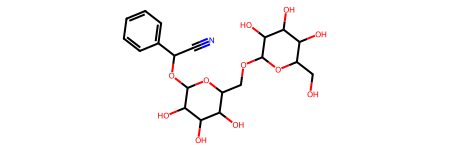

In [4]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [45]:
data

ESOL(1128)

In [41]:
# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

In [43]:
for batch in loader:
    print(batch)
    break

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'torch_geometric.data.data.Data'>

In [4]:
import torch.nn as nn
import torch

class BilinearDecoder(nn.Module):
    def __init__(self, num_users, num_items, num_rating_levels, hidden_dim):
        super(BilinearDecoder, self).__init__()
        self.Q = nn.Parameter(torch.randn(hidden_dim, num_rating_levels, hidden_dim))
        self.user_embedding = nn.Embedding(num_users, hidden_dim)
        self.item_embedding = nn.Embedding(num_items, hidden_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.num_rating_levels = num_rating_levels
        
    def forward(self, user_indices, item_indices):
        user_embeddings = self.user_embedding(user_indices)
        item_embeddings = self.item_embedding(item_indices)
        print(user_embeddings.unsqueeze(2).shape, self.Q.shape)
        bilinear_products = torch.matmul(user_embeddings.unsqueeze(2), self.Q)
        bilinear_products = torch.matmul(bilinear_products, item_embeddings.unsqueeze(1))
        rating_probs = self.softmax(bilinear_products.view(-1, self.num_rating_levels))
        return rating_probs


# Define the hyperparameters
num_users = 100
num_items = 200
num_rating_levels = 5
hidden_dim = 50

# Create a batch of user-item pairs
batch_size = 32
user_indices = torch.randint(num_users, size=(batch_size,))
item_indices = torch.randint(num_items, size=(batch_size,))

# Create an instance of the bilinear decoder
decoder = BilinearDecoder(num_users, num_items, num_rating_levels, hidden_dim)

# Compute the predicted rating probabilities for the batch
rating_probs = decoder(user_indices, item_indices)

# Print the shape of the output tensor
print(rating_probs.shape)


torch.Size([32, 50, 1]) torch.Size([50, 5, 50])


RuntimeError: The size of tensor a (32) must match the size of tensor b (50) at non-singleton dimension 0

In [4]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)     
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

def save_checkpoint(state, filename = 'checkpoint.pth.tar'):
    print('Saving checkpoint ==>>')
    torch.save(state, filename)

def load_checkpoint(checkpoint_path):
    print('Loading Checkpoing ==>>')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])


print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
      save_checkpoint(checkpoint)
      print(f"Epoch {epoch} | Train Loss {loss}")

In [7]:
# Visualize learning (training loss)
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

: 

: 

In [5]:
def load_checkpoint(checkpoint_path):
    print('Loading Checkpoing ==>>')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [6]:
import seaborn as sns

Loading Checkpoing ==>>
2323


<AxesSubplot:xlabel='y_real', ylabel='y_pred'>

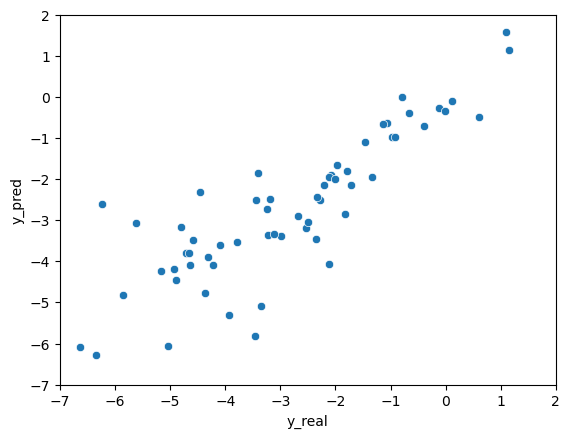

In [7]:
import pandas as pd 

load_checkpoint('checkpoint.pth.tar')
# Analyze the results for one batch
#model = torch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
print(2323)
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

In [15]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, GATConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GATConv(embedding_size, embedding_size, heads=3, concat=False)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=2, concat=False)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GATConv(64, 64, heads=3)
  (conv2): GATConv(64, 64, heads=2)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  26177


In [16]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)     
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding


print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
      save_checkpoint(checkpoint)
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Saving checkpoint ==>>
Epoch 0 | Train Loss 7.432424545288086
Saving checkpoint ==>>
Epoch 100 | Train Loss 1.0947860479354858
Saving checkpoint ==>>
Epoch 200 | Train Loss 0.5690834522247314
Saving checkpoint ==>>
Epoch 300 | Train Loss 0.36598876118659973
Saving checkpoint ==>>
Epoch 400 | Train Loss 0.3962383270263672
Saving checkpoint ==>>
Epoch 500 | Train Loss 0.3234870731830597
Saving checkpoint ==>>
Epoch 600 | Train Loss 0.7849053740501404
Saving checkpoint ==>>
Epoch 700 | Train Loss 0.2792257070541382
Saving checkpoint ==>>
Epoch 800 | Train Loss 0.4121960699558258
Saving checkpoint ==>>
Epoch 900 | Train Loss 0.026720764115452766
Saving checkpoint ==>>
Epoch 1000 | Train Loss 0.0579131543636322
Saving checkpoint ==>>
Epoch 1100 | Train Loss 0.3430059254169464
Saving checkpoint ==>>
Epoch 1200 | Train Loss 0.07266966253519058
Saving checkpoint ==>>
Epoch 1300 | Train Loss 0.12433604151010513
Saving checkpoint ==>>
Epoch 1400 | Train Loss 0.02075189538300